# Tutorial

This is a tutorial for MB-MVPA using task-fMRI data of Mixed-gamble task by Tom et al., 2007. 



### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [ ]:
from time import perf_counter

In [2]:
from mbmvpa.preprocessing.preprocess import DataPreprocessor

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


TODO: add original data download link

Data download from AWS S3, ~ <b>1GB</b> (would be under the "Mixed-gamble_task/example_data/").<br>

We provide a small subset (2 subjects) of original Tom's dataset (16 subjects). The fMRI images in the example is preprocessed by conventional fMRI preprocessing pipeline by using 
[*fmriprep*](https://fmriprep.org/en/stable/) v.20.1.0. Please refer to the [original](https://openneuro.org/datasets/ds000005/versions/00001) for more information.

In [3]:
#root = load_example_data("tom")
root = "/data2/project_modelbasedMVPA/ds000005"

### Preprocessing fMRI images and behavioral data

MB-MVPA requires primariliy preprocessed task-fMRI experiments data fromatted in conventional [BIDS format](https://bids-specification.readthedocs.io/en/stable/) 

It expects the following organized files. All the naming conventions used here conform with outputs from *fmriprep* v.20.1.0. by Poldrack lab.

The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

In [4]:
s = perf_counter()

dm_model = 'ra_prospect'

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_filter(row):
    # include all trial data
    return True

def example_latent(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row


preprocessor = DataPreprocessor(bids_layout=root,
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               latent_function=example_latent,
                               dm_model=dm_model,
                               zoom=(2,2,2))
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.40 minutes


In [5]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


In [6]:
s = perf_counter()

#preprocessor.preprocess(overwrite=True,core=16)
#preprocessor.preprocess(overwrite=True,core=16)
#feature_name = 'voxelfeaturemasked'
preprocessor.X_generator.run(overwrite=True)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

12it [03:01, 15.08s/it]

elapsed time: 3.14 minutes


In [7]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


### Load data and shape check

In [8]:
from mbmvpa.data.loader import BIDSDataLoader

In [9]:
s = perf_counter()

#loader = BIDSDataLoader(layout=root,feature_name=feature_name)
loader = BIDSDataLoader(layout=root)
X,y = loader.get_total_data()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.17 minutes


In [10]:
print("X", X.shape)
print("y", y.shape)

X (11520, 571)
y (11520,)


In [11]:
voxel_mask = loader.get_voxel_mask()

### Fitting MVPA models & Results

In [12]:
from mbmvpa.models.mvpa_mlp import MLP

In [13]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[1024,512,256,128],
                activation='sigmoid',
                n_patience=30,
                n_repeat=15,
                voxel_mask = voxel_mask)



In [14]:
s = perf_counter()

coeffs = MVPA_model.run()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

[001] - score: 0.1366 p: 0.0000
[002] - score: 0.1160 p: 0.0000
[003] - score: 0.1095 p: 0.0000
[004] - score: 0.1240 p: 0.0000
[005] - score: 0.1356 p: 0.0000
[006] - score: 0.1321 p: 0.0000
[007] - score: 0.1382 p: 0.0000
[008] - score: 0.1003 p: 0.0000
[009] - score: 0.0598 p: 0.0075
[010] - score: 0.1035 p: 0.0000
[011] - score: 0.1387 p: 0.0000
[012] - score: 0.1263 p: 0.0000
[013] - score: 0.1432 p: 0.0000
[014] - score: 0.1356 p: 0.0000
[015] - score: 0.1004 p: 0.0000
elapsed time: 18.61 minutes


[001] - score: 0.0047 p: 0.8324
[002] - score: 0.0394 p: 0.0778
[003] - score: 0.0042 p: 0.8501
[004] - score: 0.0413 p: 0.0647
[005] - score: 0.0243 p: 0.2778
[006] - score: 0.0340 p: 0.1285
[007] - score: 0.0045 p: 0.8415
[008] - score: 0.0194 p: 0.3856
[009] - score: -0.0361 p: 0.1062
[010] - score: 0.0126 p: 0.5732
[011] - score: -0.0052 p: 0.8176
[012] - score: -0.0155 p: 0.4893
[013] - score: -0.0164 p: 0.4646
[014] - score: 0.0120 p: 0.5910
[015] - score: -0.0032 p: 0.8851


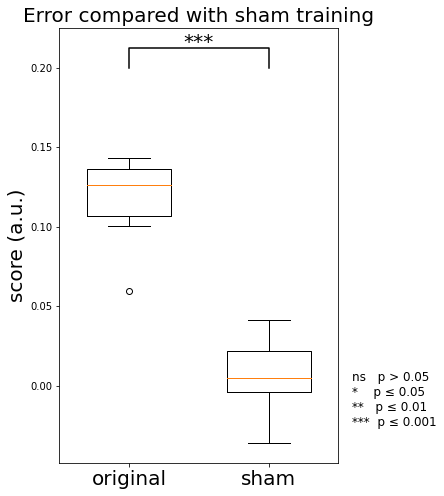

elapsed time: 20.64 minutes


In [15]:
s = perf_counter()

sham_errors = MVPA_model.sham()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

In [16]:
img = MVPA_model.image(save_path='.', task_name='example')